# OPTI556 HW3 Problem 3,4 Chini Tang

# Problem 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from skimage.transform import radon, rescale,  resize, warp
from scipy import interpolate
from skimage.transform import iradon_sart
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


SART (1 iteration) rms reconstruction error: 0.158


/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


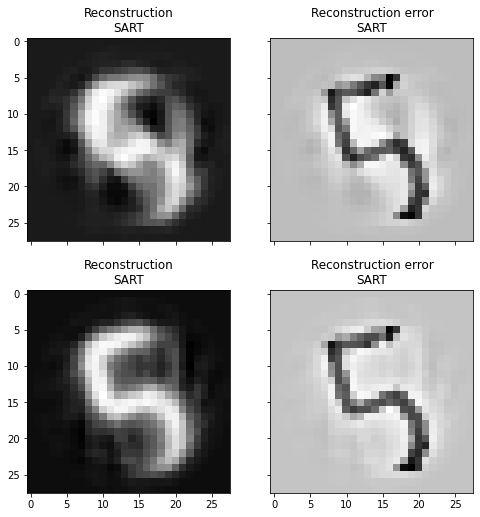

In [ ]:
ntheta=10
image=x_train[1024,:,:]
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image


fig, axes = plt.subplots(2, 2, figsize=(8, 8.5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].set_title("Reconstruction\nSART")
ax[0].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[1].set_title("Reconstruction error\nSART")
ax[1].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)
# no try with regularly spaced samples
thetaVals=np.linspace(0,180,ntheta)
sinogram=radon(image,thetaVals);
reconstruction_sart = iradon_sart(sinogram, theta=thetaVals)
error = reconstruction_sart - image
print("SART (1 iteration) rms reconstruction error: "
      f"{np.sqrt(np.mean(error**2)):.3g}")

ax[2].set_title("Reconstruction\nSART")
ax[2].imshow(reconstruction_sart, cmap=plt.cm.Greys_r)

ax[3].set_title("Reconstruction error\nSART")
ax[3].imshow(reconstruction_sart - image, cmap=plt.cm.Greys_r)

Data preparation (without noise).

We import mnist dataset as the training data target, and minst dataset with radon transform as the input. Usually, the raw data obtained from CT should be the target image after radon transform, called sinogram, which is hard to find the features. So it is hard to train the network if we use those images as training datset. Therefore, we should do inverse radon tranform to obtain the more reasonable reconstructed images, and set those images as the training dataset.

In [ ]:

# load the mnist dataset of characters
from keras.datasets import mnist

ntheta=20;
# randomly spaced values of theta
thetaVals=np.random.choice(360,ntheta,replace=False)/2.


(x_train, __), (x_test, __) = mnist.load_data()
x_train = x_train[0:30000,:,:]
x_test = x_test[0:5000,:,:]
#
# image padding to full radon data from all directions.
#
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0


g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= iradon_sart(radon(x_test[pop,:,:],thetaVals), theta=thetaVals)
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=iradon_sart(radon(x_train[pop,:,:],thetaVals), theta=thetaVals)
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


Data preparation (with noise).

We can also add the poisson noise to our training dataset.

In [ ]:
ntheta=20;
thetaVals=np.random.choice(360,ntheta,replace=False)/2.
nPhoto=1

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train =np.pad(x_train, ((0,0),(18,18),(18,18)), 'constant')
x_test =np.pad(x_test, ((0,0),(18,18),(18,18)), 'constant')

x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

x_train = x_train[0:30000,:,:]
x_test = x_test[0:5000,:,:]

g_test = np.zeros(np.shape(x_test))
g_train = np.zeros(np.shape(x_train))

for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:] = iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_test[pop,:,:],thetaVals))), theta=thetaVals)
  g_test[pop,:,:] = g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:] = iradon_sart(28.*nPhoto-np.random.poisson(nPhoto*(28.-radon(x_train[pop,:,:],thetaVals))), theta=thetaVals)
  g_train[pop,:,:] = g_train[pop,:,:]/np.max(g_train[pop,:,:])
  
x_train = np.reshape(x_train, (len(x_train), 64, 64, 1))
x_test = np.reshape(x_test, (len(x_test), 64, 64, 1))
g_train = np.reshape(g_train, (len(g_train), 64, 64, 1))
g_test = np.reshape(g_test, (len(g_test), 64, 64, 1))

/usr/local/lib/python3.7/dist-packages/skimage/transform/radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


1.0


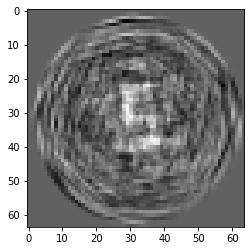

In [ ]:
plt.imshow(g_test[1931].reshape(64, 64))
print(np.max(g_test[1931]))

## Original network

Create two idenfical network, one will be trained by data without noise, the other will be trained by noised data.

In [ ]:

inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder = keras.Model(inputs, x)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_2 = keras.Model(inputs, x)
autoencoder_2.compile(optimizer='adam', loss='mean_squared_error')


autoencoder_2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 64, 64, 16)        4624

start training (without noise)

In [ ]:
autoencoder.fit(
    x=g_train,
    y=x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/50
235/235 [==============================] - 59s 122ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 2/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 3/50
235/235 [==============================] - 29s 122ms/step - loss: 9.6696e-04 - val_loss: 8.5551e-04
Epoch 4/50
235/235 [==============================] - 29s 123ms/step - loss: 8.0318e-04 - val_loss: 7.3624e-04
Epoch 5/50
235/235 [==============================] - 29s 123ms/step - loss: 7.2432e-04 - val_loss: 6.6757e-04
Epoch 6/50
235/235 [==============================] - 29s 123ms/step - loss: 6.5894e-04 - val_loss: 6.4412e-04
Epoch 7/50
235/235 [==============================] - 29s 122ms/step - loss: 6.1438e-04 - val_loss: 5.9141e-04
Epoch 8/50
235/235 [==============================] - 28s 121ms/step - loss: 5.7417e-04 - val_loss: 5.7487e-04
Epoch 9/50
235/235 [==============================] - 28s 121ms/step - loss: 5.5160e-04 - val_loss: 5.3460e-04
Epoch 10/50
235/2

start training (with noise)
Same network structure but train with noised dataset

In [ ]:
autoencoder_2.fit(
    x=g_train,
    y=x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/50
235/235 [==============================] - 29s 120ms/step - loss: 0.0067 - val_loss: 0.0044
Epoch 2/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 3/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 7/50
235/235 [==============================] - 28s 120ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 8/50
235/235 [==============================] - 28s 119ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 9/50
235/235 [==============================] - 28s 119ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/50
235/235 [==============================] - 28s 120ms/step - l

show the results (with noise)

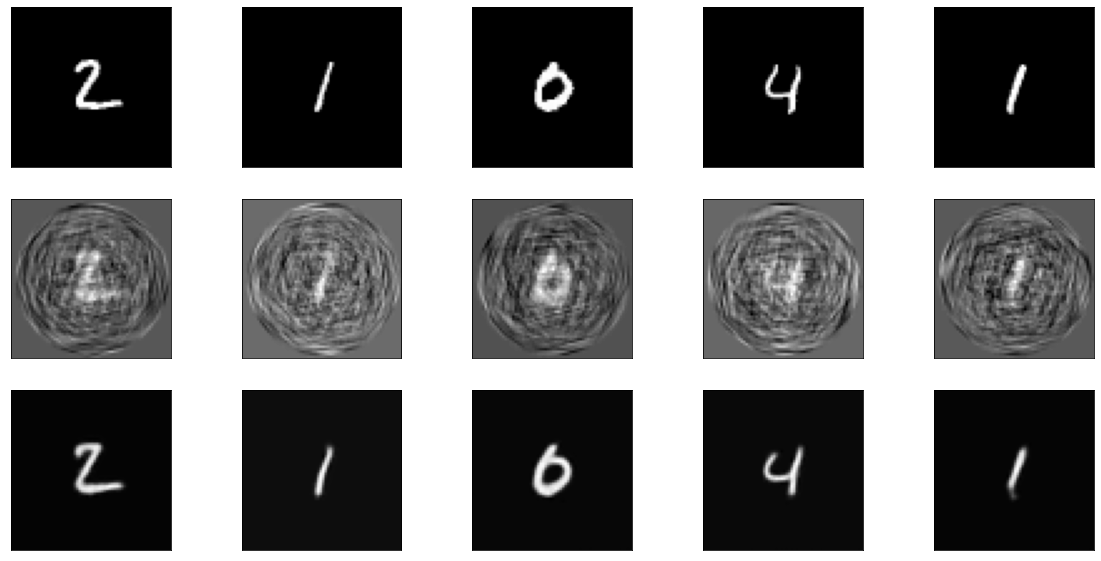

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_2.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

show the results (without noise)

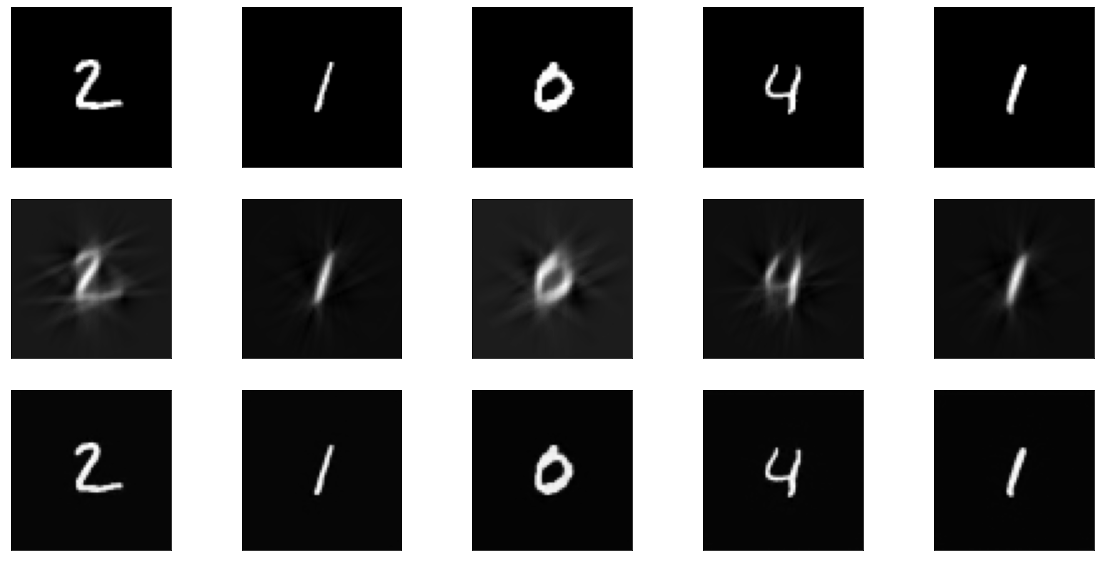

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## My network

I add a maxpooling layer and makes stride=1 for my encoder.
It is better to use maxpooling than stride=2 to reduce the image size.

In [ ]:
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, add


inputs=keras.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (4, 4), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)


autoencoder_3 = keras.Model(inputs, x)
autoencoder_3.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_4 = keras.Model(inputs, x)
autoencoder_4.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_4.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 32, 32, 32)        1846

start training (without noise)

In [ ]:
autoencoder_3.fit(
    x=g_train,
    y=x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/50
235/235 [==============================] - 25s 103ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 2/50
235/235 [==============================] - 24s 100ms/step - loss: 0.0010 - val_loss: 8.3820e-04
Epoch 3/50
235/235 [==============================] - 24s 100ms/step - loss: 7.9009e-04 - val_loss: 7.3361e-04
Epoch 4/50
235/235 [==============================] - 23s 100ms/step - loss: 6.6627e-04 - val_loss: 7.0081e-04
Epoch 5/50
235/235 [==============================] - 23s 100ms/step - loss: 5.9828e-04 - val_loss: 5.4601e-04
Epoch 6/50
235/235 [==============================] - 24s 100ms/step - loss: 5.6030e-04 - val_loss: 5.1721e-04
Epoch 7/50
235/235 [==============================] - 24s 100ms/step - loss: 5.2021e-04 - val_loss: 5.5624e-04
Epoch 8/50
235/235 [==============================] - 24s 100ms/step - loss: 4.8469e-04 - val_loss: 4.6125e-04
Epoch 9/50
235/235 [==============================] - 23s 100ms/step - loss: 4.6774e-04 - val_loss: 4.5745e-04
Epoch 10/50
2

start training (with noise)

In [ ]:
autoencoder_4.fit(
    x=g_train,
    y=x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/50
235/235 [==============================] - 25s 102ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 2/50
235/235 [==============================] - 23s 100ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 3/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 4/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 5/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 7/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 8/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 9/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/50
235/235 [==============================] - 23s 99ms/step - loss: 0.0

show the results (without noise)

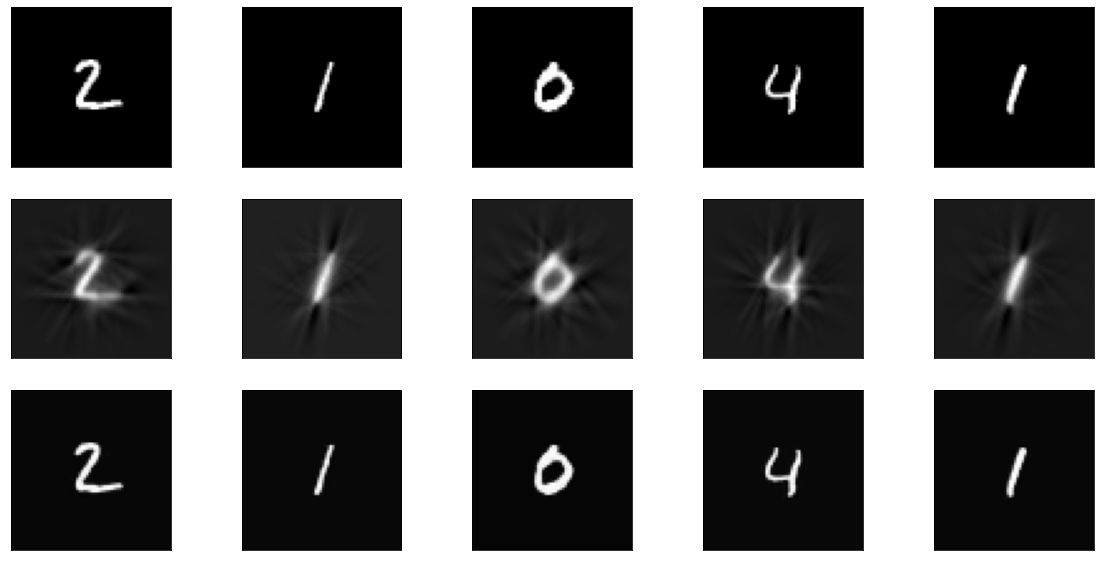

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_3.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

show the results (with noise)

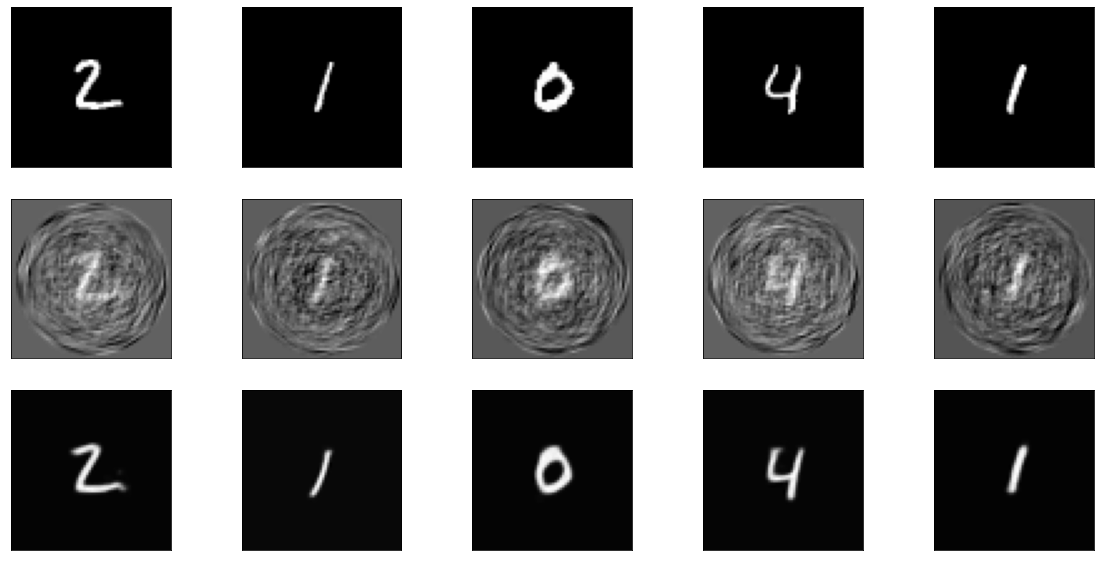

In [ ]:
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_4.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

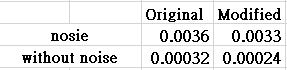

In conclusion, i create two different network, one is original network, the other is modified network. For both with and without noise training dataset, my modified network has lower validation loss, which is better than the original network.

# Problem 4

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from scipy import signal
from scipy import integrate
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist

In [ ]:
l= 10
delta=1
N=28
M=128
code=np.random.randint(0,2,M)
def t(x):
  t=code[np.int(np.floor((x+M/2)/delta))]
  return t
vt=np.vectorize(t)
def p(j):
  xj, yj=delta*divmod(j,N)
  xj=xj-N*delta/2
  yj=yj+l
  return xj, yj
def g(j,x):
  g=t((x+(l/p(j)[1])*p(j)[0])/(1+(l/p(j)[1])))
  return g
def h(i,j):
  h=integrate.quad(lambda x: g(j,x), (i-M/2)*delta-delta/2,(i-M/2)*delta +delta/2)[0]
  return h
H=np.zeros((M,N**2))
for j in range(N**2):
  for i in range(M):
    H[i,j]=h(i,j)

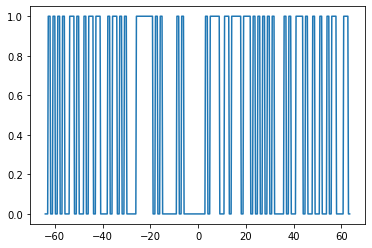

In [ ]:
xspace=np.linspace(-M*delta/2,(M-1)*delta/2,512)
plt.plot(xspace,vt(xspace))

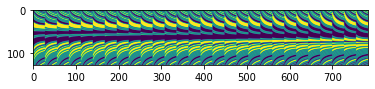

In [ ]:
plt.imshow(H)

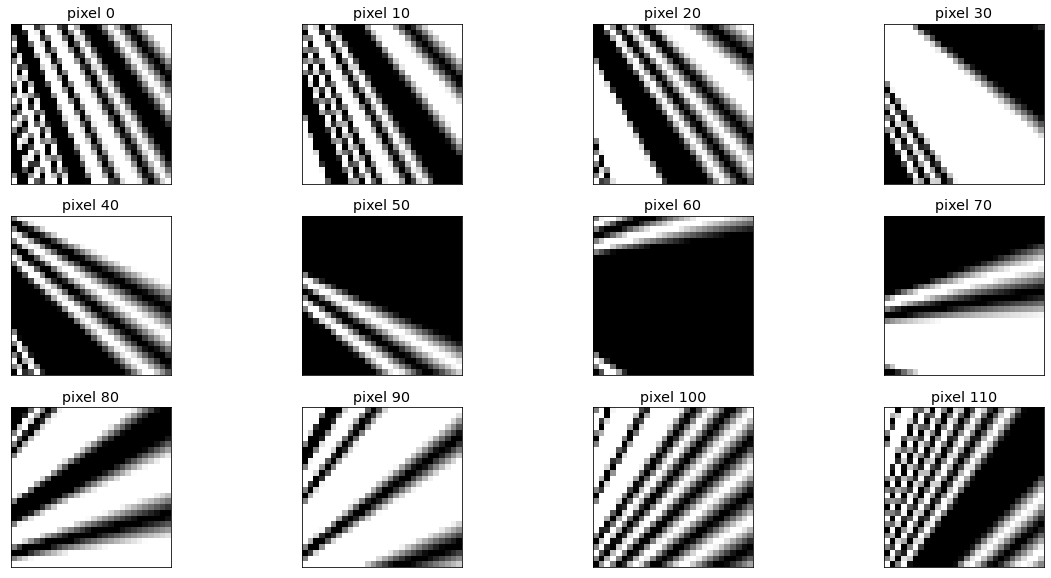

In [ ]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 12})
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(H[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('pixel '+np.str(10*i))

In [ ]:
u, lam, vh = np.linalg.svd(H)
ph=np.linalg.pinv(H)

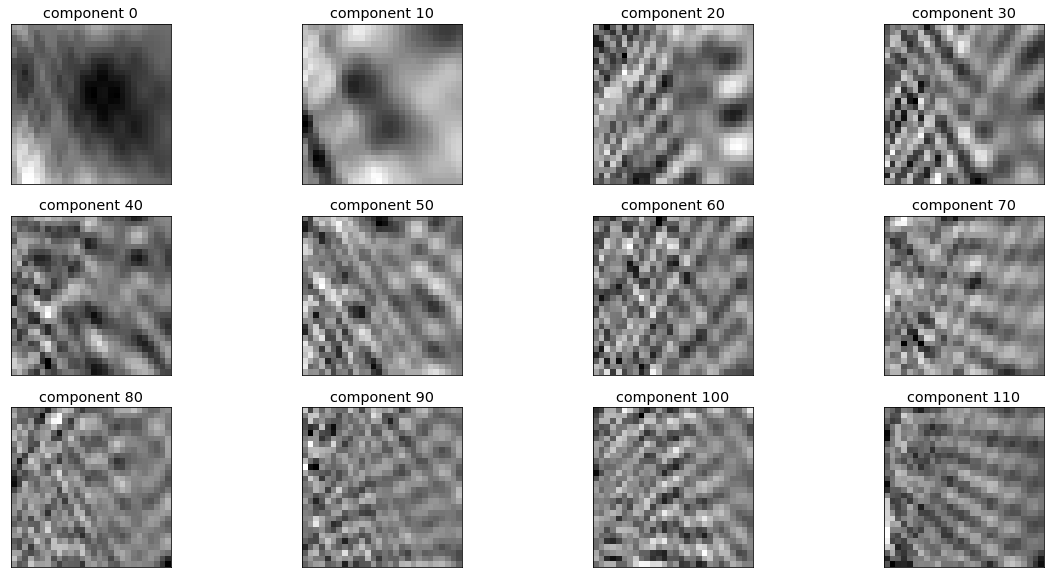

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(np.reshape(vh[10*i,:],(N,N)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('component '+np.str(10*i))

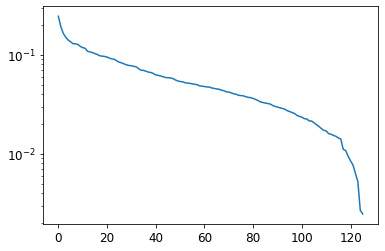

In [ ]:
plt.semilogy(lam[1:127]/lam[0])

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

11501568/11490434 [==============================] - 0s 0us/step


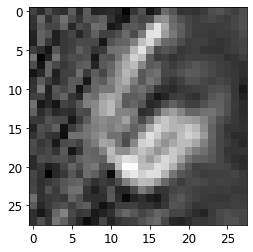

In [ ]:
plt.imshow(np.reshape(np.matmul(np.linalg.pinv(H),np.matmul(H,np.reshape(x_train[32],N**2))),(N,N)))

prepare for training dataset

In [ ]:

g_test=np.zeros(np.shape(x_test))
g_train=np.zeros(np.shape(x_train))
for pop in range(np.shape(x_test)[0]):
  g_test[pop,:,:]= np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_test[pop],N**2))),(N,N))
  g_test[pop,:,:]=g_test[pop,:,:]/np.max(g_test[pop,:,:])
for pop in range(np.shape(x_train)[0]):
  g_train[pop,:,:]=np.reshape(np.matmul(ph,np.matmul(H,np.reshape(x_train[pop],N**2))),(N,N))
  g_train[pop,:,:]=g_train[pop,:,:]/np.max(g_train[pop,:,:])
x_train = np.reshape(x_train, (len(x_train), N, N, 1))
x_test = np.reshape(x_test, (len(x_test), N, N, 1))
g_train = np.reshape(g_train, (len(g_train), N, N, 1))
g_test = np.reshape(g_test, (len(g_test), N, N, 1))

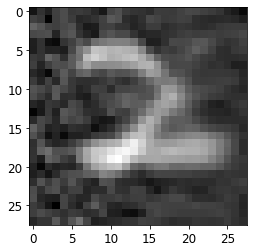

In [ ]:
plt.imshow(g_test[1932].reshape(N, N))

In [ ]:
inputs=keras.Input(shape=(N, N, 1))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(32, (4, 4), strides=2, activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

autoencoder_5 = keras.Model(inputs, x)
autoencoder_5.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        16416     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 16)        4624  

In [ ]:
autoencoder_5.fit(
    x=g_train,
    y=x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

Epoch 1/30
469/469 [==============================] - 44s 28ms/step - loss: 0.0164 - val_loss: 0.0080
Epoch 2/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 3/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0064 - val_loss: 0.0060
Epoch 4/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 5/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 6/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 7/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 8/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/30
469/469 [==============================] - 13s 27ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 10/30
469/469 [==============================] - 13s 27ms/step - loss: 0.004

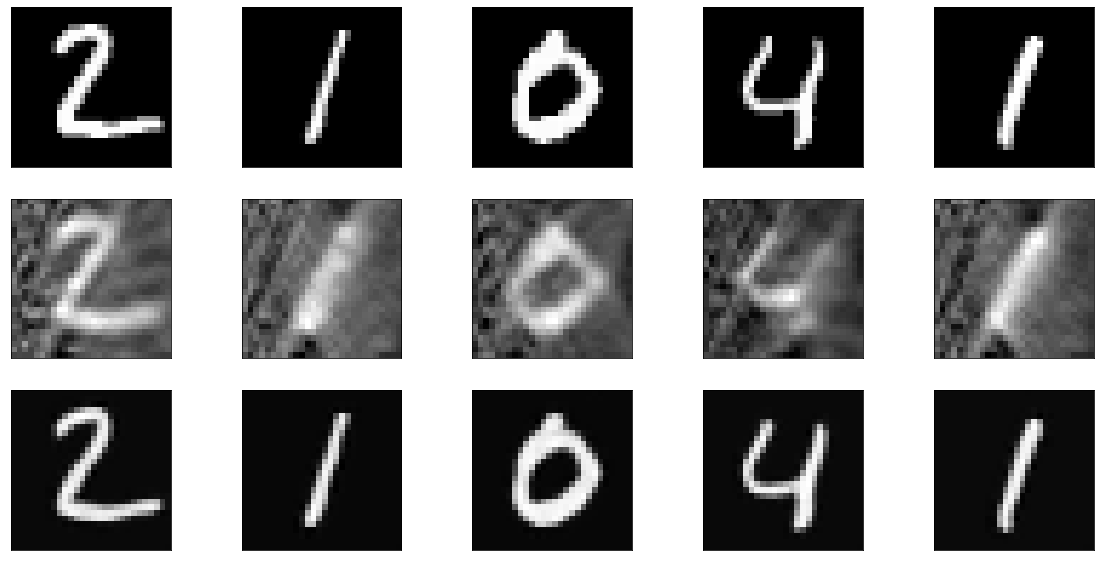

In [ ]:

n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i].reshape(N, N))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(autoencoder_5.predict(g_test[i:(i+1),:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)